# Topic modeling on PWDB textual data

## Importing libraries

In [1]:
import sys
sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os
os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

from gensim.models import LdaModel, LsiModel
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import filter_stop_words,\
    filter_pos, filter_stop_words_on_a_span_list, select_pos, spacy_stop_words

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

## Fetching data from document store

In [2]:
pwdb = Dataset.PWDB.fetch()

pwdb.fillna(value="", inplace=True)

document_corpus = pwdb['title'].map(str) + '. ' + \
                  pwdb['background_info_description'].map(str) + '. ' + \
                  pwdb['content_of_measure_description'].map(str) + '. ' + \
                  pwdb['use_of_measure_description'] + '. ' + \
                  pwdb['involvement_of_social_partners_description']

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


## Data preprocessing

- data cleanup
- turn corpus into spacy Docs

In [3]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]

document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words
   - nouns
   - verbs
   - noun phrases

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



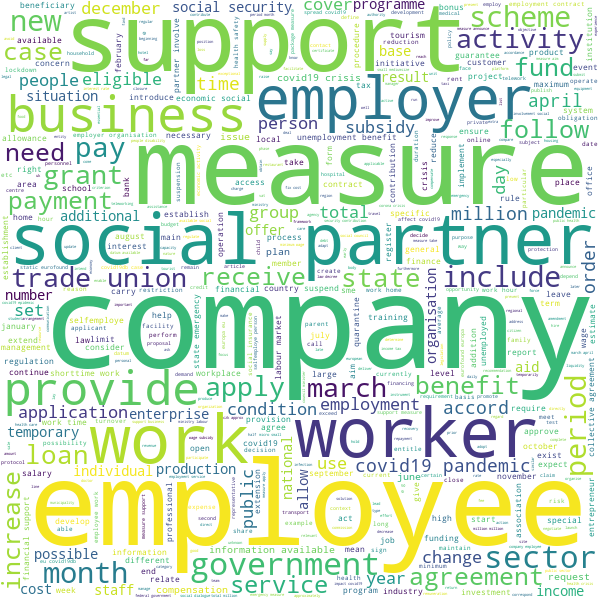

In [4]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in word_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



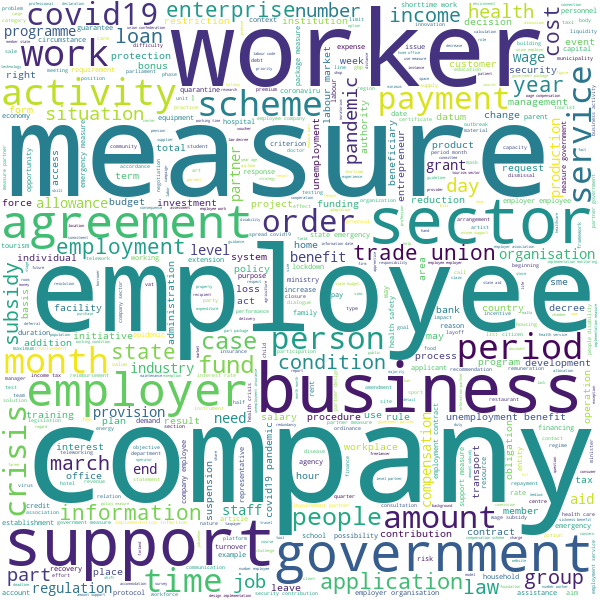

In [5]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



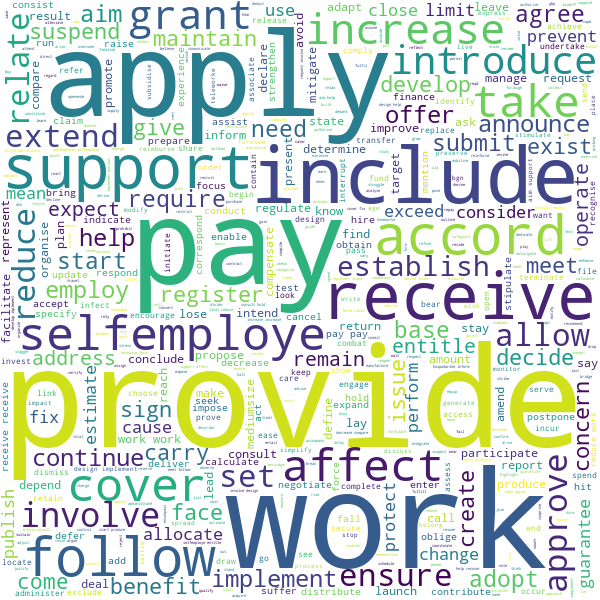

In [6]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(filter_stop_words)
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in verb_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



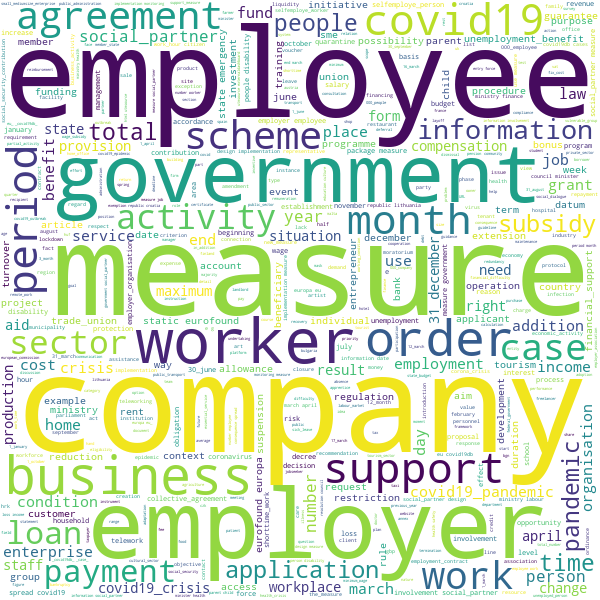

In [7]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA + LSI models

- create a dictionary and a corpus with each corpora
- train LDA models
- train LSI models
- visualize the results (LDA)

In [8]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(noun_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=5, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=5, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

word_lsa_model = LsiModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=300)
noun_lsa_model = LsiModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=300)
verb_lsa_model = LsiModel(corpus=verb_gensim_corpus, num_topics=6, id2word=verb_dictionary, chunksize=300)
noun_phrases_lsa_model = LsiModel(corpus=noun_phrases_gensim_corpus, num_topics=6, id2word=noun_phrases_dictionary, chunksize=300)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.060066  0.038731       1        1  28.411344
4     -0.091134  0.132803       2        1  25.404103
0      0.054490 -0.233831       3        1  23.375106
3     -0.205731 -0.028762       4        1  14.067269
2      0.182309  0.091059       5        1   8.742178, topic_info=            Term         Freq        Total Category  logprob  loglift
572      benefit   826.000000   826.000000  Default  30.0000  30.0000
215        leave   642.000000   642.000000  Default  29.0000  29.0000
95          work  2269.000000  2269.000000  Default  28.0000  28.0000
1233        loan   659.000000   659.000000  Default  27.0000  27.0000
965          day   727.000000   727.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
34      employee   120.918309  2307.090402   Topic5  -5.2306  -0.5116
7          apply   108.238776   780.025428   Topic5  -5.3413   0.4620
59        number   105.611826   626.089780   Topic5  -5.3659   0.6573
24       covid19   111.325197  2103.124646   Topic5  -5.3132  -0.5017
339   government   106.651641  1433.904513   Topic5  -5.3561  -0.1616

[390 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1036      1  0.264892          1
1036      2  0.612234          1
1036      3  0.010526          1
1036      4  0.061399          1
1036      5  0.050873          1
...     ...       ...        ...
304       1  0.076075  workplace
304       3  0.922412  workplace
1773      1  0.983229   workshop
1106      1  0.123434    ziuzeop
1106      5  0.864035    ziuzeop

[845 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

In [11]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.227464  0.087742       1        1  28.705023
3     -0.002431 -0.044408       2        1  27.184692
0     -0.018791  0.077152       3        1  22.685030
1     -0.001682 -0.213246       4        1  12.253236
4     -0.204559  0.092760       5        1   9.172020, topic_info=         Term         Freq        Total Category  logprob  loglift
13   employee  2272.000000  2272.000000  Default  30.0000  30.0000
6     company  2513.000000  2513.000000  Default  29.0000  29.0000
90     health   930.000000   930.000000  Default  28.0000  28.0000
570      loan   668.000000   668.000000  Default  27.0000  27.0000
387   service   971.000000   971.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
70    covid19   107.329349  1104.040119   Topic5  -4.7764   0.0582
153    worker    99.512831  1535.264016   Topic5  -4.8521  -0.3472
212    person    78.013012   578.883804   Topic5  -5.0955   0.3848
110   measure   101.585023  3487.510793   Topic5  -4.8314  -1.1470
41       time    79.924802   787.235128   Topic5  -5.0713   0.1016

[370 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
632       2  0.089291              .
632       4  0.906649              .
2062      4  0.946907       accident
307       1  0.993965  accommodation
50        1  0.412222       activity
...     ...       ...            ...
47        3  0.048771           year
47        4  0.004720           year
47        5  0.058210           year
155       3  0.111049          youth
155       5  0.866181          youth

[745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

t-SNE for noun_lda_model

In [15]:
# Get the topics weights (nr. of docs. x nr. of topics)
weights = np.zeros((len(pwdb), 5))

for doc_nr, topics_info in enumerate(noun_lda_model[noun_gensim_corpus]):
    for topic_info in topics_info:
        topic_idx = topic_info[0]
        topic_weight = topic_info[1]
        weights[doc_nr][topic_idx] = topic_weight

# Dominant topic number in each doc
dominant_topics = np.argmax(weights, axis=1)

# t-SNE Dimension Reduction
t_sne_model = TSNE(n_components=2, verbose=1, random_state=42)
t_sne_lda = t_sne_model.fit_transform(weights)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
colors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

source = ColumnDataSource(dict(
    x=t_sne_lda[:,0],
    y=t_sne_lda[:,1],
    color=colors[dominant_topics],
    label=pd.Series(dominant_topics).apply(lambda x: "Topic " + str(x + 1))
))

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)

plot.scatter(x="x", y="y", color="color", legend_group="label", source=source)

# Display legend in the top left corner
plot.legend.location = "top_left"

# Add a title to your legend
plot.legend.title = "Topics"

show(plot)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1288 samples in 0.001s...
[t-SNE] Computed neighbors for 1288 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1288
[t-SNE] Computed conditional probabilities for sample 1288 / 1288
[t-SNE] Mean sigma: 0.083925


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.333172


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[t-SNE] KL divergence after 1000 iterations: 0.724486


Loading BokehJS ...

In [13]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.074422 -0.184612       1        1  32.146293
2      0.101537 -0.079620       2        1  31.912983
1      0.210129  0.127484       3        1  22.601819
0     -0.237244  0.136748       4        1  13.338905, topic_info=            Term        Freq        Total Category  logprob  loglift
84   selfemploye  515.000000   515.000000  Default  30.0000  30.0000
282       reduce  545.000000   545.000000  Default  29.0000  29.0000
55           pay  937.000000   937.000000  Default  28.0000  28.0000
281       follow  466.000000   466.000000  Default  27.0000  27.0000
58       receive  881.000000   881.000000  Default  26.0000  26.0000
..           ...         ...          ...      ...      ...      ...
234         plan   53.696410   145.535158   Topic4  -4.7027   1.0174
15       provide   67.591308  1053.808077   Topic4  -4.4726  -0.7322
144       create   42.971533    87.252872   Topic4  -4.9255   1.3062
37       develop   49.114442   198.103413   Topic4  -4.7919   0.6198
514          run   43.048785   104.391431   Topic4  -4.9237   1.1287

[260 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
305       1  0.027361     access
305       2  0.054723     access
305       4  0.902922     access
205       1  0.974434  accompany
205       3  0.030451  accompany
...     ...       ...        ...
642       1  0.955278       wish
22        1  0.285329       work
22        2  0.630418       work
22        3  0.000842       work
22        4  0.084168       work

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [14]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.108644  0.111544       1        1  32.511167
3      0.081011  0.142485       2        1  25.955625
1     -0.163325 -0.100291       3        1  19.987853
4      0.081805 -0.035722       4        1  11.421127
2      0.109153 -0.118016       5        1  10.124228, topic_info=         Term         Freq        Total Category  logprob  loglift
13   employee  1449.000000  1449.000000  Default  30.0000  30.0000
4     company  1447.000000  1447.000000  Default  29.0000  29.0000
907      loan   276.000000   276.000000  Default  28.0000  28.0000
14   employer   830.000000   830.000000  Default  27.0000  27.0000
253   measure  1977.000000  1977.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
4     company    57.950358  1447.321862   Topic5  -5.3313  -0.9276
53       year    39.772348   273.474586   Topic5  -5.7077   0.3622
143   payment    39.393562   346.280116   Topic5  -5.7173   0.1166
196      fund    31.022279   209.772099   Topic5  -5.9562   0.3789
216     total    28.942480   219.464844   Topic5  -6.0256   0.2644

[335 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
673       2  0.989073     12_march
717       1  0.991757     13_march
2204      5  0.939819     15_march
2590      5  0.942547  1_september
2205      2  0.064504     20_march
...     ...       ...          ...
53        2  0.515587         year
53        3  0.106043         year
53        4  0.073133         year
53        5  0.146266         year
790       1  0.966537      ziuzeop

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])